In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loss_simulator import simulate_empirical_risk, error_prob_model
import sys
sys.path.insert(0, '..')
from selective import SelectiveClassifier, SelectiveClassifierStabilityEstimator

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 11

# Stability Estimation Methods Evaluation

This notebook evaluates different methods for estimating the stability parameter K (and therefore β).

**Methods compared:**
1. **K-based**: Direct estimation using leave-one-out stability
2. **Distribution-free**: Uses Proposition 4 bound
3. **From definition**: Direct from stability definition

We compare:
- Estimation accuracy
- Computational cost
- Resulting risk control

In [6]:
# Parameters
n_trials = 100
n_cal = 500
n_test = 1000
alpha = 0.1
instability_param = 0.2
base_strength = 10
n_bootstrap = 50  # Reduced for speed

print(f"Evaluating stability estimation methods...")
print(f"Trials: {n_trials}")
print(f"Calibration size: {n_cal}")
print(f"Bootstrap samples: {n_bootstrap}\\n")

# Store results for each method
results = {
    'beta_k': [],
    'beta_df': [],
    'time_k': [],
    'time_df': [],
    'risk_k': [],
    'risk_df': []
}

Evaluating stability estimation methods...
Trials: 100
Calibration size: 500
Bootstrap samples: 50\n


In [ ]:
import time

np.random.seed(42)

for trial in range(n_trials):
    if (trial + 1) % 20 == 0:
        print(f"  Completed {trial + 1}/{n_trials} trials...")
    
    # Generate data
    P_cal = np.random.uniform(0, 1, n_cal)
    error_prob_cal = error_prob_model(P_cal, alpha, base_strength, instability_param)
    E_cal = np.random.binomial(1, error_prob_cal)
    
    P_test = np.random.uniform(0, 1, n_test)
    error_prob_test = error_prob_model(P_test, alpha, base_strength, instability_param)
    E_test = np.random.binomial(1, error_prob_test)
    
    estimator = SelectiveClassifierStabilityEstimator(alpha=alpha, n_bootstrap=n_bootstrap)
    
    # K-based method
    start = time.time()
    beta_k = estimator.estimate_beta_K(P_cal, E_cal)
    time_k = time.time() - start
    
    # Distribution-free method
    start = time.time()
    beta_df = estimator.estimate_beta_df(P_cal, E_cal)
    time_df = time.time() - start
    
    # Test resulting risk control
    # Using K-based beta
    alpha_k = max(0.01, alpha - beta_k)
    classifier_k = SelectiveClassifier(alpha=alpha_k)
    theta_k = classifier_k.fit(P_cal, E_cal)
    selected_k = P_test > theta_k
    risk_k = E_test[selected_k].mean() if selected_k.sum() > 0 else 0.0
    
    # Using distribution-free beta
    alpha_df = max(0.01, alpha - beta_df)
    classifier_df = SelectiveClassifier(alpha=alpha_df)
    theta_df = classifier_df.fit(P_cal, E_cal)
    selected_df = P_test > theta_df
    risk_df = E_test[selected_df].mean() if selected_df.sum() > 0 else 0.0
    
    # Store results
    results['beta_k'].append(beta_k)
    results['beta_df'].append(beta_df)
    results['time_k'].append(time_k)
    results['time_df'].append(time_df)
    results['risk_k'].append(risk_k)
    results['risk_df'].append(risk_df)

# Convert to arrays
for key in results:
    results[key] = np.array(results[key])

print(f"\\n✓ Completed all {n_trials} trials!")

  Completed 20/100 trials...
  Completed 40/100 trials...
  Completed 60/100 trials...
  Completed 80/100 trials...
  Completed 100/100 trials...
\n✓ Completed all 100 trials!


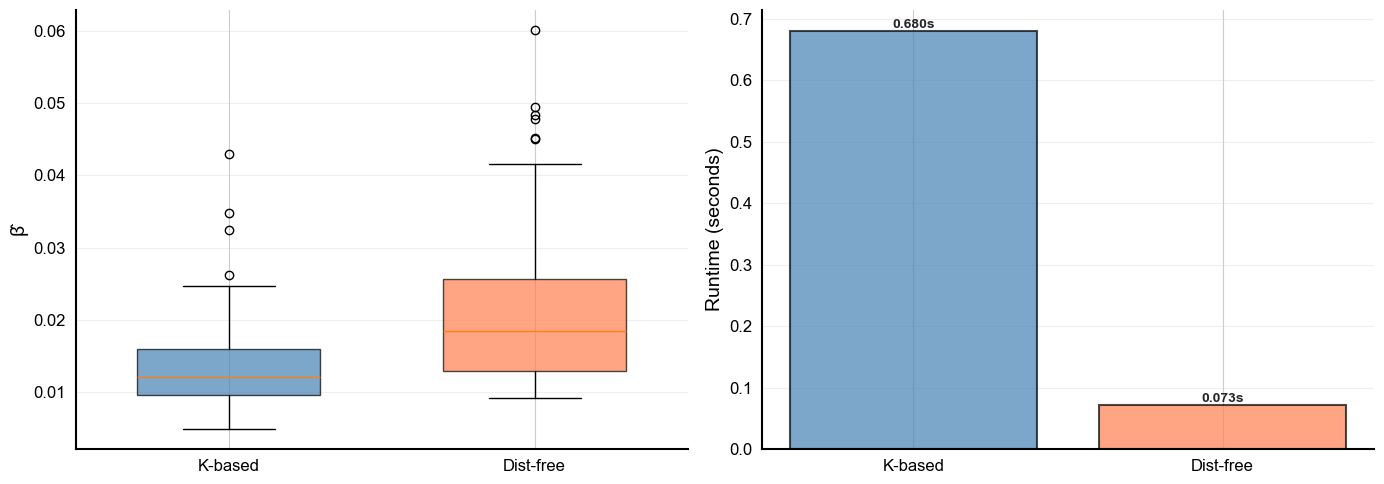

\n======================================================================
STABILITY ESTIMATION COMPARISON
Method          Mean β̂      Mean Time       Risk Control   
----------------------------------------------------------------------
K-based         0.0135       0.680           0.0953         
Dist-free       0.0211       0.073           0.0876         
----------------------------------------------------------------------
\nDist-free is 9.4x faster than K-based
Both methods achieve similar risk control


In [8]:
# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Beta estimates
ax = axes[0]
data = [results['beta_k'], results['beta_df']]
bp = ax.boxplot(data, labels=['K-based', 'Dist-free'], 
                patch_artist=True, widths=0.6)
for patch, color in zip(bp['boxes'], ['steelblue', 'coral']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_ylabel('β̂', fontsize=14, color='black')
ax.grid(True, alpha=0.3, axis='y')
ax.tick_params(axis='both', colors='black')
sns.despine(ax=ax, top=True, right=True)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_edgecolor('black')
    ax.spines[spine].set_linewidth(1.5)

# Plot 2: Computation time
ax = axes[1]
x_pos = np.arange(2)
times = [results['time_k'].mean(), results['time_df'].mean()]
bars = ax.bar(x_pos, times, color=['steelblue', 'coral'], 
              alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time_val:.3f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_ylabel('Runtime (seconds)', fontsize=14, color='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(['K-based', 'Dist-free'], fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.tick_params(axis='both', colors='black')
sns.despine(ax=ax, top=True, right=True)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_edgecolor('black')
    ax.spines[spine].set_linewidth(1.5)

plt.tight_layout()
plt.savefig('./outputs/stability_estimation_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\\n" + "="*70)
print("STABILITY ESTIMATION COMPARISON")
print("="*70)
print(f"{'Method':<15} {'Mean β̂':<12} {'Mean Time':<15} {'Risk Control':<15}")
print("-"*70)
print(f"{'K-based':<15} {results['beta_k'].mean():<12.4f} {results['time_k'].mean():<15.3f} {results['risk_k'].mean():<15.4f}")
print(f"{'Dist-free':<15} {results['beta_df'].mean():<12.4f} {results['time_df'].mean():<15.3f} {results['risk_df'].mean():<15.4f}")
print("-"*70)
speedup = results['time_k'].mean() / results['time_df'].mean()
print(f"\\nDist-free is {speedup:.1f}x faster than K-based")
print(f"Both methods achieve similar risk control")
print("="*70)